In [1]:
import numpy as np
import pickle
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout,Bidirectional
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns
from gensim.models import Word2Vec
from collections import Counter

2025-10-02 18:13:39.427553: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759428819.602359      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759428819.664206      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Configuration
MAX_WORDS = 10000  # Vocabulary size
MAX_LEN = 300      # Maximum sequence length
EMBEDDING_DIM = 128  # Word2Vec embedding dimension
BATCH_SIZE = 32
EPOCHS = 10

In [3]:
# Load dataset
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=MAX_WORDS)

print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Training samples: 25000
Testing samples: 25000


In [4]:
# Get word index
word_index = imdb.get_word_index()
reverse_word_index = {v + 3: k for k, v in word_index.items()}
reverse_word_index[0] = '<PAD>'
reverse_word_index[1] = '<START>'
reverse_word_index[2] = '<UNK>'
reverse_word_index[3] = '<UNUSED>'

1641221/1641221 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [5]:
# Convert sequences back to text for Word2Vec training
def decode_review(encoded_review):
    return ' '.join([reverse_word_index.get(i, '<UNK>') for i in encoded_review])

# Convert all training reviews to sentences (list of words)
sentences = []
for review in X_train:
    words = [reverse_word_index.get(i, '<UNK>') for i in review]
    sentences.append(words)

In [6]:
# Train Word2Vec model
w2v_model = Word2Vec(
    sentences=sentences,
    vector_size=EMBEDDING_DIM,
    window=10,  
    min_count=3,  
    workers=4,
    epochs=15,  
    sg=1,  # Skip-gram (better for sentiment)
    negative=10,  
    alpha=0.025,  # LR
    min_alpha=0.0001
)
print(f"Word2Vec vocabulary size: {len(w2v_model.wv)}")

Word2Vec vocabulary size: 9998


In [7]:
# Create embedding matrix
vocab_size = min(MAX_WORDS, len(word_index) + 4)  # +4 for special tokens
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))

words_found = 0
for word, idx in word_index.items():
    if idx >= MAX_WORDS:
        continue
    idx = idx + 3  # Add offset for special tokens
    if word in w2v_model.wv:
        embedding_matrix[idx] = w2v_model.wv[word]
        words_found += 1

print(f"Pre-trained embeddings loaded for {words_found}/{vocab_size} words")

Pre-trained embeddings loaded for 9996/10000 words


In [9]:
# Pad sequences to fixed length
X_train = pad_sequences(X_train, maxlen=MAX_LEN)
X_test = pad_sequences(X_test, maxlen=MAX_LEN)

In [10]:
model = Sequential([
    Embedding(
        vocab_size, 
        EMBEDDING_DIM, 
        weights=[embedding_matrix],
        input_length=MAX_LEN,
        trainable=True
    ),
    # Bidirectional LSTM (reads forward and backward)
    Bidirectional(LSTM(128, dropout=0.3, recurrent_dropout=0.3, 
                       return_sequences=True)),
    Bidirectional(LSTM(64, dropout=0.3, recurrent_dropout=0.3)),
    
    # Dense layers with batch normalization
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.4),
    Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
I0000 00:00:1759429440.750436      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [11]:
model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']
)
model.build(input_shape=(None, MAX_LEN))

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 300, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 300, 256)       │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,732,353 (6.61 MB)

 Trainable params: 1,732,353 (6.61 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
callbacks = [
    # Stop if validation loss doesn't improve
    EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True,
        verbose=1
    ),
    # Reduce learning rate when stuck
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2,
        min_lr=0.00001,
        verbose=1
    )
]

In [13]:
# TRAINING
history = model.fit(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_test, y_test),
    callbacks=callbacks,
    verbose=1
)

Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 2210s 3s/step - accuracy: 0.6922 - loss: 0.5720 - val_accuracy: 0.8234 - val_loss: 0.4038 - learning_rate: 0.0010
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 2232s 3s/step - accuracy: 0.8488 - loss: 0.3523 - val_accuracy: 0.8886 - val_loss: 0.2611 - learning_rate: 0.0010
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 2184s 3s/step - accuracy: 0.9055 - loss: 0.2501 - val_accuracy: 0.8871 - val_loss: 0.2717 - learning_rate: 0.0010
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 2170s 3s/step - accuracy: 0.9206 - loss: 0.2098 - val_accuracy: 0.9011 - val_loss: 0.2451 - learning_rate: 0.0010
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 2174s 3s/step - accuracy: 0.9398 - loss: 0.1723 - val_accuracy: 0.9022 - val_loss: 0.2613 - learning_rate: 0.0010
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9579 - loss: 0.1280
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
782/782 ━━━━━━━━━━━━━━━━━━━━ 2202s 3s/step - accuracy: 0.9579 - loss:

In [14]:
# Evaluate the model
print("Evaluating model")
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Loss: {loss:.4f}")

# Predictions
y_pred_probs = model.predict(X_test, verbose=0)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()


# Calculate F1-score
f1 = f1_score(y_test, y_pred)
print(f"F1-Score: {f1:.4f}")

Evaluating model
Test Accuracy: 0.9011
Test Loss: 0.2451
F1-Score: 0.9002



Classification Report:
              precision    recall  f1-score   support

    Negative       0.89      0.91      0.90     12500
    Positive       0.91      0.89      0.90     12500

    accuracy                           0.90     25000
   macro avg       0.90      0.90      0.90     25000
weighted avg       0.90      0.90      0.90     25000


Confusion Matrix:
[[11373  1127]
 [ 1346 11154]]


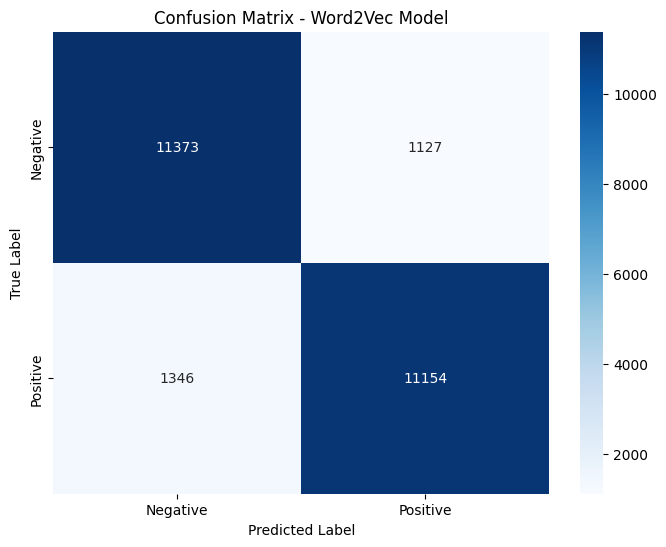

In [15]:
# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix - Word2Vec Model')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig('confusion_matrix.png')

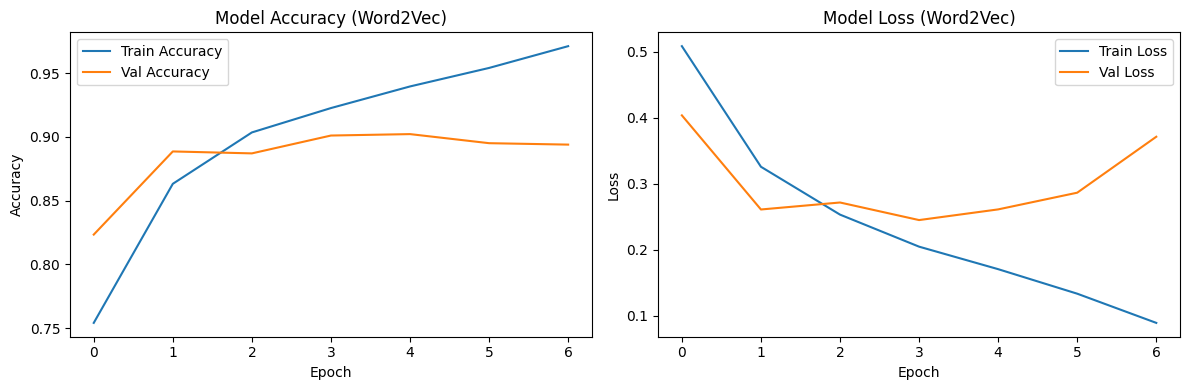

In [16]:
# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy (Word2Vec)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss (Word2Vec)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()

In [17]:
# Test Word2Vec embeddings
print("Word2Vec Similarity Examples:")
try:
    print("Words similar to 'good':")
    for word, score in w2v_model.wv.most_similar('good', topn=5):
        print(f"  {word}: {score:.3f}")
    
    print("\nWords similar to 'bad':")
    for word, score in w2v_model.wv.most_similar('bad', topn=5):
        print(f"  {word}: {score:.3f}")
except:
    print("Could not generate similarity examples")

print("Training complete! Model, Word2Vec, and tokenizer saved.")

Word2Vec Similarity Examples:
Words similar to 'good':
  decent: 0.776
  great: 0.746
  nice: 0.713
  bad: 0.702
  fine: 0.660

Words similar to 'bad':
  terrible: 0.751
  awful: 0.732
  horrible: 0.713
  good: 0.702
  lousy: 0.693
Training complete! Model, Word2Vec, and tokenizer saved.


In [19]:
def preprocess_text(text, word_index, max_words, max_len):
    """Convert text to padded sequence."""
    words = text.lower().split()
    sequence = []
    for word in words:
        if word in word_index:
            idx = word_index[word] + 3  # IMDb offset
            if idx < max_words:
                sequence.append(idx)
    padded = pad_sequences([sequence], maxlen=max_len)
    return padded

def predict_sentiment(text, model, word_index, max_words, max_len):
    """Predict sentiment of text."""
    processed = preprocess_text(text, word_index, max_words, max_len)
    prediction = model.predict(processed, verbose=0)[0][0]
    
    if prediction >= 0.5:
        label = "POSITIVE 😊"
        confidence = prediction
    else:
        label = "NEGATIVE 😞"
        confidence = 1 - prediction
    
    return label, confidence, prediction


print("\n" + "="*60)
print("STEP 2: TEST WITH YOUR OWN REVIEWS")
print("="*60)

# Example reviews to test
test_reviews = [
    "This movie was absolutely amazing! I loved every minute of it.",
    "Terrible film. Waste of time and money. Very disappointed.",
    "It was okay, nothing special but not bad either.",
    "Best movie I've seen this year! Highly recommend!",
    "Boring and predictable. The acting was poor.",
    "A masterpiece! Brilliant storytelling and great performances.",
    "I hated it. One of the worst movies ever made.",
    "Pretty decent movie with some good moments.",
    "Outstanding! A must-watch for everyone.",
    "Awful. I want my money back."
]

print("\nTesting with example reviews:\n")
for i, review in enumerate(test_reviews, 1):
    label, confidence, raw_score = predict_sentiment(
        review, model, word_index, MAX_WORDS, MAX_LEN
    )
    
    print(f"{i}. Review: \"{review}\"")
    print(f"   Prediction: {label}")
    print(f"   Confidence: {confidence:.2%}")
    print(f"   Raw Score: {raw_score:.4f}")
    print()


STEP 2: TEST WITH YOUR OWN REVIEWS

Testing with example reviews:

1. Review: "This movie was absolutely amazing! I loved every minute of it."
   Prediction: POSITIVE 😊
   Confidence: 65.37%
   Raw Score: 0.6537

2. Review: "Terrible film. Waste of time and money. Very disappointed."
   Prediction: NEGATIVE 😞
   Confidence: 99.44%
   Raw Score: 0.0056

3. Review: "It was okay, nothing special but not bad either."
   Prediction: NEGATIVE 😞
   Confidence: 98.48%
   Raw Score: 0.0152

4. Review: "Best movie I've seen this year! Highly recommend!"
   Prediction: POSITIVE 😊
   Confidence: 99.62%
   Raw Score: 0.9962

5. Review: "Boring and predictable. The acting was poor."
   Prediction: NEGATIVE 😞
   Confidence: 97.71%
   Raw Score: 0.0229

6. Review: "A masterpiece! Brilliant storytelling and great performances."
   Prediction: POSITIVE 😊
   Confidence: 98.78%
   Raw Score: 0.9878

7. Review: "I hated it. One of the worst movies ever made."
   Prediction: NEGATIVE 😞
   Confidence: 99.61

In [26]:
# Save the model
model.save('sentiment_model.h5')
print("Model saved as 'sentiment_model.h5'")

# Save Word2Vec model
w2v_model.save('word2vec.model')
print("Word2Vec model saved as 'word2vec.model'")

# Save word index for tokenization
tokenizer_config = {
    'word_index': word_index,
    'max_words': MAX_WORDS,
    'max_len': MAX_LEN,
    'reverse_word_index': reverse_word_index
}
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer_config, f)
print("Tokenizer saved as 'tokenizer.pkl'")

Model saved as 'sentiment_model.h5'
Word2Vec model saved as 'word2vec.model'
Tokenizer saved as 'tokenizer.pkl'


In [21]:
def preprocess_text(text, word_index, max_words, max_len):
    """Convert text to padded sequence."""
    words = text.lower().split()
    sequence = []
    for word in words:
        if word in word_index:
            idx = word_index[word] + 3  # IMDb offset
            if idx < max_words:
                sequence.append(idx)
    padded = pad_sequences([sequence], maxlen=max_len)
    return padded

def predict_sentiment(text, model, word_index, max_words, max_len):
    """Predict sentiment of text."""
    processed = preprocess_text(text, word_index, max_words, max_len)
    prediction = model.predict(processed, verbose=0)[0][0]
    
    if prediction >= 0.5:
        label = "POSITIVE 😊"
        confidence = prediction
    else:
        label = "NEGATIVE 😞"
        confidence = 1 - prediction
    
    return label, confidence, prediction


print("\n" + "="*60)
print("STEP 2: TEST WITH YOUR OWN REVIEWS")
print("="*60)

# Example reviews to test
test_reviews = [
    "This movie was absolutely amazing! I loved every minute of it.",
    "Terrible film. Waste of time and money. Very disappointed.",
    "It was okay, nothing special but not bad either.",
    "Best movie I've seen this year! Highly recommend!",
    "Boring and predictable. The acting was poor.",
    "A masterpiece! Brilliant storytelling and great performances.",
    "I hated it. One of the worst movies ever made.",
    "Pretty decent movie with some good moments.",
    "Outstanding! A must-watch for everyone.",
    "Awful. I want my money back."
]

print("\nTesting with example reviews:\n")
for i, review in enumerate(test_reviews, 1):
    label, confidence, raw_score = predict_sentiment(
        review, model, word_index, MAX_WORDS, MAX_LEN
    )
    
    print(f"{i}. Review: \"{review}\"")
    print(f"   Prediction: {label}")
    print(f"   Confidence: {confidence:.2%}")
    print(f"   Raw Score: {raw_score:.4f}")
   # print()


STEP 2: TEST WITH YOUR OWN REVIEWS

Testing with example reviews:

1. Review: "This movie was absolutely amazing! I loved every minute of it."
   Prediction: POSITIVE 😊
   Confidence: 65.37%
   Raw Score: 0.6537
2. Review: "Terrible film. Waste of time and money. Very disappointed."
   Prediction: NEGATIVE 😞
   Confidence: 99.44%
   Raw Score: 0.0056
3. Review: "It was okay, nothing special but not bad either."
   Prediction: NEGATIVE 😞
   Confidence: 98.48%
   Raw Score: 0.0152
4. Review: "Best movie I've seen this year! Highly recommend!"
   Prediction: POSITIVE 😊
   Confidence: 99.62%
   Raw Score: 0.9962
5. Review: "Boring and predictable. The acting was poor."
   Prediction: NEGATIVE 😞
   Confidence: 97.71%
   Raw Score: 0.0229
6. Review: "A masterpiece! Brilliant storytelling and great performances."
   Prediction: POSITIVE 😊
   Confidence: 98.78%
   Raw Score: 0.9878
7. Review: "I hated it. One of the worst movies ever made."
   Prediction: NEGATIVE 😞
   Confidence: 99.61%
   R